In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from scipy.stats import mstats
from scipy import stats

In [2]:
df = pd.read_csv('../Dataset/SelectedFeatures-10s-TOR-NonTOR.csv')

In [3]:
print(df.shape)

(67834, 29)


In [4]:
print(df.head())

   Source IP   Source Port  Destination IP   Destination Port   Protocol  \
0  10.0.2.15         53913   216.58.208.46                 80          6   
1  10.0.2.15         53913   216.58.208.46                 80          6   
2  10.0.2.15         53913   216.58.208.46                 80          6   
3  10.0.2.15         53913   216.58.208.46                 80          6   
4  10.0.2.15         53913   216.58.208.46                 80          6   

    Flow Duration   Flow Bytes/s   Flow Packets/s   Flow IAT Mean  \
0             435            0.0      4597.701149           435.0   
1             259            0.0      7722.007722           259.0   
2             891            0.0      2244.668911           891.0   
3            1074            0.0      1862.197393          1074.0   
4             315            0.0      6349.206349           315.0   

    Flow IAT Std  ...   Bwd IAT Min  Active Mean   Active Std   Active Max  \
0            0.0  ...             0            0  

In [5]:
print(df.describe())

        Source Port   Destination Port      Protocol   Flow Duration  \
count  67834.000000       67834.000000  67834.000000    6.783400e+04   
mean   37912.753324       11566.395967     12.167291    2.991884e+06   
std    20986.077326       18374.765123      5.459410    4.063005e+06   
min       21.000000          21.000000      6.000000    0.000000e+00   
25%    19305.000000         137.000000      6.000000    4.435975e+04   
50%    43677.000000         443.000000     17.000000    4.108570e+05   
75%    54685.000000       16311.000000     17.000000    7.325550e+06   
max    65534.000000       65514.000000     17.000000    1.000000e+07   

        Flow Bytes/s   Flow Packets/s   Flow IAT Mean   Flow IAT Std  \
count   6.783200e+04     6.783400e+04    6.783400e+04   6.783400e+04   
mean             inf              inf    3.155927e+05   2.209662e+05   
std              NaN              NaN    6.988069e+05   6.409506e+05   
min     0.000000e+00     2.002581e-01    0.000000e+00   0.00000

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67834 entries, 0 to 67833
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Source IP          67834 non-null  object 
 1    Source Port       67834 non-null  int64  
 2    Destination IP    67834 non-null  object 
 3    Destination Port  67834 non-null  int64  
 4    Protocol          67834 non-null  int64  
 5    Flow Duration     67834 non-null  int64  
 6    Flow Bytes/s      67832 non-null  float64
 7    Flow Packets/s    67834 non-null  float64
 8    Flow IAT Mean     67834 non-null  float64
 9    Flow IAT Std      67834 non-null  float64
 10   Flow IAT Max      67834 non-null  int64  
 11   Flow IAT Min      67834 non-null  int64  
 12  Fwd IAT Mean       67834 non-null  float64
 13   Fwd IAT Std       67834 non-null  float64
 14   Fwd IAT Max       67834 non-null  int64  
 15   Fwd IAT Min       67834 non-null  int64  
 16  Bwd IAT Mean       678

In [7]:
print(df['label'].value_counts())

label
nonTOR    59790
TOR        8044
Name: count, dtype: int64


In [8]:
duplicati = df[df.duplicated()]
numero_duplicati = df.duplicated().sum()
print('Numero di duplicati: ', numero_duplicati)

Numero di duplicati:  396


In [9]:
df = df.drop_duplicates()
print(df.shape)

(67438, 29)


In [10]:
categorical_features = ["Source IP", " Destination IP"]
numeric_features = df.columns.difference(categorical_features + ["label"])

In [11]:
upper_limit = 1e9
lower_limit = -1e9
df[numeric_features] = df[numeric_features].applymap(lambda x: min(upper_limit, max(lower_limit, x)))

In [12]:
df = df.replace([np.inf, -np.inf], np.nan)
nan_values = df.isna().sum()
print(nan_values)

Source IP            0
 Source Port         0
 Destination IP      0
 Destination Port    0
 Protocol            0
 Flow Duration       0
 Flow Bytes/s        0
 Flow Packets/s      0
 Flow IAT Mean       0
 Flow IAT Std        0
 Flow IAT Max        0
 Flow IAT Min        0
Fwd IAT Mean         0
 Fwd IAT Std         0
 Fwd IAT Max         0
 Fwd IAT Min         0
Bwd IAT Mean         0
 Bwd IAT Std         0
 Bwd IAT Max         0
 Bwd IAT Min         0
Active Mean          0
 Active Std          0
 Active Max          0
 Active Min          0
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
label                0
dtype: int64


In [13]:
df = df.copy()
df.dropna(inplace=True)
df.shape

(67438, 29)

eslorazione feature presente in altro notebook

In [14]:
unique_value_columns = df[numeric_features].nunique() == 1
columns_to_drop = unique_value_columns[unique_value_columns].index
numeric_features = [col for col in numeric_features if col not in columns_to_drop]
df = df.drop(columns=columns_to_drop)
df.shape

(67438, 27)

In [15]:
print(df.isnull().sum())

Source IP            0
 Source Port         0
 Destination IP      0
 Destination Port    0
 Protocol            0
 Flow Duration       0
 Flow Bytes/s        0
 Flow Packets/s      0
 Flow IAT Mean       0
 Flow IAT Std        0
 Flow IAT Max        0
 Flow IAT Min        0
Fwd IAT Mean         0
 Fwd IAT Std         0
 Fwd IAT Max         0
 Fwd IAT Min         0
Bwd IAT Mean         0
 Bwd IAT Std         0
 Bwd IAT Max         0
 Bwd IAT Min         0
Active Mean          0
 Active Max          0
 Active Min          0
Idle Mean            0
 Idle Max            0
 Idle Min            0
label                0
dtype: int64


In [16]:
df.drop_duplicates()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0.000000e+00,4.597701e+03,435.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0.000000e+00,7.722008e+03,259.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0.000000e+00,2.244669e+03,891.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0.000000e+00,1.862197e+03,1074.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0.000000e+00,6.349206e+03,315.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67828,10.8.8.134,34251,134.170.18.137,443,6,0,1.000000e+09,1.000000e+09,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
67829,131.202.240.183,7116,239.255.255.250,1900,17,0,1.000000e+09,1.000000e+09,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
67831,131.202.240.87,11365,31.13.73.1,443,6,0,1.000000e+09,1.000000e+09,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR
67832,131.202.6.26,13000,131.202.240.87,64584,6,0,-1.000000e+09,1.000000e+09,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,nonTOR


In [17]:
unique_value_columns = df[numeric_features].nunique() == 1
columns_to_drop = unique_value_columns[unique_value_columns].index
numeric_features = [col for col in numeric_features if col not in columns_to_drop]
df = df.drop(columns=columns_to_drop)
df.shape

(67438, 27)

In [18]:
correlation_matrix = df[numeric_features].corr()
print(correlation_matrix)

                    Active Max   Active Min   Bwd IAT Max   Bwd IAT Min  \
 Active Max           1.000000     1.000000      0.258695      0.021293   
 Active Min           1.000000     1.000000      0.258695      0.021293   
 Bwd IAT Max          0.258695     0.258695      1.000000      0.336636   
 Bwd IAT Min          0.021293     0.021293      0.336636      1.000000   
 Bwd IAT Std          0.229649     0.229649      0.813534      0.011329   
 Destination Port     0.014921     0.014921      0.062334      0.077656   
 Flow Bytes/s        -0.002798    -0.002798     -0.005024     -0.002518   
 Flow Duration        0.191988     0.191988      0.417554      0.102815   
 Flow IAT Max         0.370287     0.370287      0.718086      0.243033   
 Flow IAT Mean        0.253508     0.253508      0.072244      0.202254   
 Flow IAT Min         0.198525     0.198525     -0.110027     -0.027600   
 Flow IAT Std         0.231033     0.231033      0.476469      0.398582   
 Flow Packets/s      -0.0

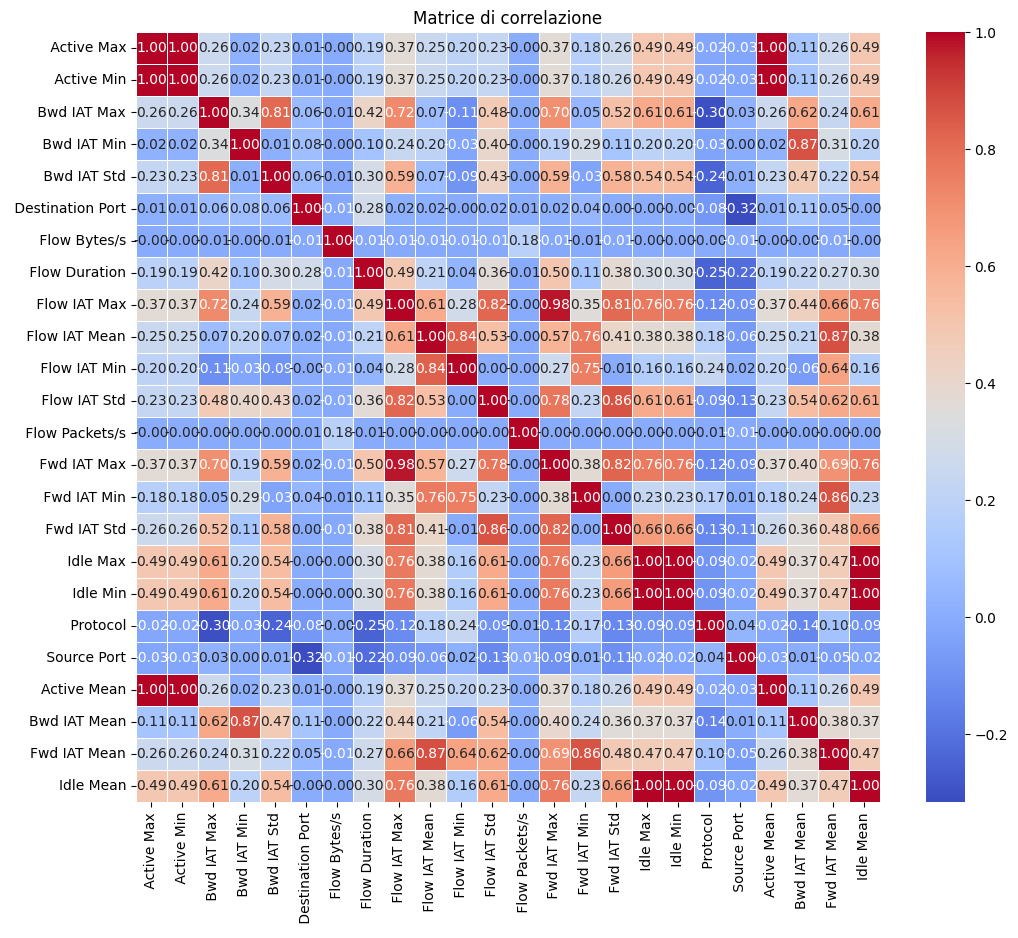

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matrice di correlazione')
plt.show()

In [20]:
def correlation(df, threshold):
    col_corr = set()  
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

highly_correlated_features = correlation(df[numeric_features], 0.9)
print("Feature altamente correlate:", highly_correlated_features)

Feature altamente correlate: {' Active Min', ' Fwd IAT Max', 'Active Mean', 'Idle Mean', ' Idle Min'}


In [21]:
df.drop(columns=highly_correlated_features, inplace=True)

In [22]:
print(df.shape)

(67438, 22)


In [23]:
scaler = StandardScaler()

In [24]:
missing_values_count = df['label'].isna().sum()
print(missing_values_count)

0


In [25]:
top_n_categories = 40
for column in categorical_features:
    top_categories = df[column].value_counts().nlargest(top_n_categories).index
    df[column] = df[column].where(df[column].isin(top_categories), 'Other')

In [26]:
#encoder = OneHotEncoder(sparse=False, drop='first') 
#df_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

#df = pd.concat([df, df_encoded], axis=1)

#df.drop(categorical_features, axis=1, inplace=True)

In [27]:
df = pd.get_dummies(df, columns=['Source IP', ' Destination IP'])

In [28]:
print(df.shape)

(67438, 102)


In [29]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
class_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(class_mapping)

{0: 'TOR', 1: 'nonTOR'}


In [30]:
X = df.drop('label', axis=1)
y = df['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train_nonTOR = X_train[y_train == 1]
print(X_train_nonTOR.shape)
X_train_nonTOR_scaled = scaler.fit_transform(X_train_nonTOR)

(47526, 101)


In [33]:
start_time= time.time()
lof_model_nonTOR = LocalOutlierFactor(n_neighbors=8, contamination=0.1192, novelty=True)
lof_model_nonTOR.fit(X_train_nonTOR_scaled)
end_time = time.time()
print("Tempo di addestramento: ", end_time-start_time)

Tempo di addestramento:  19.707983016967773


In [34]:
y_test_distances = -lof_model_nonTOR.decision_function(X_test)
print(y_test_distances)

[ 13361.51374187  23289.74289446 217658.17065584 ...  21556.69152092
  19861.99994951  32933.12202651]


In [35]:
X_test_scaled = scaler.transform(X_test)
start_time = time.time()
y_test_pred = lof_model_nonTOR.predict(X_test_scaled)
end_time = time.time()
print("Tempo di predizione: ", end_time-start_time)

Tempo di predizione:  5.148988246917725


[[ 1580    34]
 [ 1476 10398]]


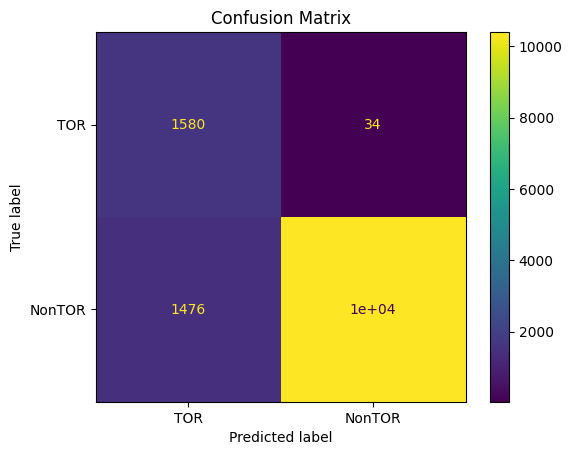

In [36]:
y_test_pred_binary = np.where(y_test_pred == -1, 0, 1)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['TOR', 'NonTOR'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [37]:
classification_report_test = classification_report(y_test, y_test_pred_binary)
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.52      0.98      0.68      1614
           1       1.00      0.88      0.93     11874

    accuracy                           0.89     13488
   macro avg       0.76      0.93      0.80     13488
weighted avg       0.94      0.89      0.90     13488



Versione outlier detection

In [38]:
start_time= time.time()
lof_model_nonTOR_2 = LocalOutlierFactor(n_neighbors=50, contamination=0.25, novelty=False)
lof_model_nonTOR_2.fit(X_train_nonTOR_scaled)
end_time = time.time()
print("Tempo di addestramento: ", end_time-start_time)

Tempo di addestramento:  20.14730954170227


In [39]:
start_time = time.time()
y_test_pred = lof_model_nonTOR_2.fit_predict(X_test_scaled)
end_time = time.time()
print("Tempo di predizione: ", end_time-start_time)

Tempo di predizione:  2.0691685676574707


[[ 405 1209]
 [2967 8907]]


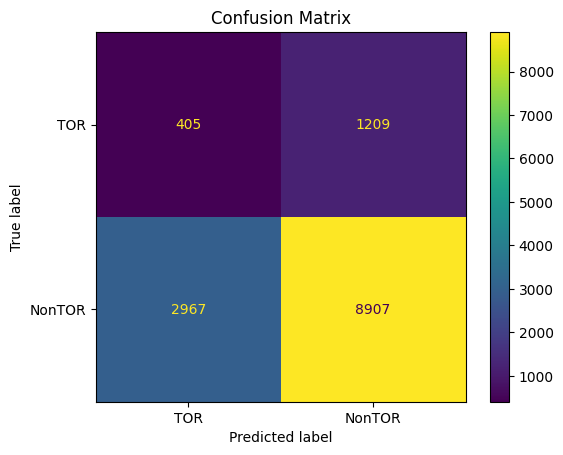

In [40]:
y_test_pred_binary = np.where(y_test_pred == -1, 0, 1)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['TOR', 'NonTOR'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [41]:
classification_report_test = classification_report(y_test, y_test_pred_binary)
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.12      0.25      0.16      1614
           1       0.88      0.75      0.81     11874

    accuracy                           0.69     13488
   macro avg       0.50      0.50      0.49     13488
weighted avg       0.79      0.69      0.73     13488



In [42]:
isolation_model = IsolationForest(contamination=0.1, random_state=42)  

In [43]:
isolation_model.fit(X_train_nonTOR)

IsolationForest(contamination=0.1, random_state=42)

In [44]:
predictions = isolation_model.predict(X_test)

In [45]:
y_test_pred_binary = np.where(predictions == -1, 0, 1)

confusion_matrix(y_test, y_test_pred_binary)

array([[  123,  1491],
       [ 1190, 10684]], dtype=int64)

In [46]:
print(classification_report(y_test, y_test_pred_binary))

              precision    recall  f1-score   support

           0       0.09      0.08      0.08      1614
           1       0.88      0.90      0.89     11874

    accuracy                           0.80     13488
   macro avg       0.49      0.49      0.49     13488
weighted avg       0.78      0.80      0.79     13488



In [67]:
svm_model = OneClassSVM(nu=0.00001)

svm_model.fit(X_train_nonTOR)

OneClassSVM(nu=1e-05)

In [68]:
predictions = svm_model.predict(X_test)
print(predictions)

[1 1 1 ... 1 1 1]


In [69]:
predictions[predictions == 1] = 1  
predictions[predictions == -1] = 0  
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.22      0.00      0.01      1614
           1       0.88      1.00      0.94     11874

    accuracy                           0.88     13488
   macro avg       0.55      0.50      0.47     13488
weighted avg       0.80      0.88      0.82     13488



In [70]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[    6  1608]
 [   21 11853]]
